In [1]:
using LinearAlgebra
using PyPlot
using PyCall
import TensorCrossInterpolation as TCI
using SparseIR
using ITensors
ITensors.disable_warn_order()

BLAS.set_num_threads(1)

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["text.usetex"] = true
#rcParams["text.latex.preamble"] = [r"\usepackage{lmodern}", r"\usepackage{gensymb}", r"\usepackage{amsmath}"]

function displaymatrix(A::Matrix)
    show(stdout, "text/plain", A)
end

function maxlinkdim(n::Integer, localdim::Integer=2)
    return 0:n-2, [min(localdim^i, localdim^(n - i)) for i in 1:(n-1)]
end

maxlinkdim (generic function with 2 methods)

In [2]:
rcParams = PyDict(matplotlib["rcParams"])
rcParams["font.size"] = 18
rcParams["text.usetex"] = true
rcParams["font.family"] = "serif"
rcParams["text.latex.preamble"] = [raw"\usepackage{amsmath}"]
rcParams["font.serif"] = ["Computer Modern Roman"]

1-element Vector{String}:
 "Computer Modern Roman"

# Haldane model

- [See Haldane PRL 1988]

The Bloch Hamiltonian is a 2x2 matrix
$$
H(\mathbf{k}) =
2t_2 \cos\phi \left[ \sum_i \cos(\mathbf{k}\cdot\mathbf{b}_i) \right] \sigma^0 +
t_1 \left[ \sum_i \cos(\mathbf{k} \cdot \mathbf{a_i}) \right] \sigma^1 +
t_1 \left[ \sum_i \sin(\mathbf{k} \cdot \mathbf{a_i}) \right] \sigma^2 +
$$
$$
+\left[m - 2t_2 \sin\phi \sum_i \sin(\mathbf{k}\cdot\mathbf{b_i}) \right] \sigma^3
$$
where $\sigma^\mu$ are Pauli matrices (with identity $\sigma^0$), $a_i$ are distance vectors between nearest neighbours and $b_i$ are between next-nearest neighbours. In the following, I set $t_1 = 1$ as unit of energy, and choose $t_2 = 0.1, \phi = \pi/2$. For this choice of parameters, the model is

 * topologically nontrivial for $|m| < 0.3\sqrt 3$ with Chern number $-1$,
 
 * trivial for $|m| > 0.3\sqrt 3$ (Chern number $0$)
 
 * and has a Dirac point for $|m| = 0.3\sqrt 3$ (Chern number $-1/2$).

Close to the transition, the gap at the dirac point is approximately $2\delta m$, where $\delta m = |m - 0.3\sqrt 3|$. Accordingly, we need a lattice with resolution $\sim \delta m$ to resolve the gap and get the correct Chern number.

In [3]:
pauli0 = [1. 0.; 0. 1.]
pauli = [
    [0. 1.; 1. 0.],
    [0. -1.0im; 1.0im 0.],
    [1. 0.; 0. -1.]
]

antisymmetricproduct(u, v) = u[1] * v[2] - u[2] * v[1]
    
function haldane(k, t2, ϕ, m)
    a::Vector{Vector{Float64}} =
    [
        [1, 0],
        [-0.5, 0.5sqrt(3)],
        [-0.5, -0.5sqrt(3)]
    ]
    b::Vector{Vector{Float64}} = [a[2] - a[3], a[3] - a[1], a[1] - a[2]]

    return 2 * t2 * cos(ϕ) * sum(cos(k' * bi) for bi in b) * pauli0 +    # NNN hopping
        sum(cos(k' * ai) * pauli[1] + sin(k' * ai) * pauli[2] for ai in a) + # NN hopping
        (m - 2 * t2 * sin(ϕ) * sum(sin(k' * bi) for bi in b)) * pauli[3]    # staggered offset
end

function ghaldane(k, t2, ϕ, m, β, μ)
    ek = eigvals(haldane(k, t2, ϕ,m))
    iv = SparseIR.valueim(SparseIR.FermionicFreq(1), β)
    return sum(1 ./ (iv .- ek .+ μ))
end

ghaldane (generic function with 1 method)

In [4]:
BZcontour = [
    [2pi / 3, 2pi/(3sqrt(3))],
    [2pi / 3, -2pi/(3sqrt(3))],
    [0, -4pi/(3sqrt(3))],
    [-2pi / 3, -2pi/(3sqrt(3))],
    [-2pi / 3, 2pi/(3sqrt(3))],
    [0, 4pi/(3sqrt(3))],
    [2pi / 3, 2pi/(3sqrt(3))],
]


7-element Vector{Vector{Float64}}:
 [2.0943951023931953, 1.2091995761561452]
 [2.0943951023931953, -1.2091995761561452]
 [0.0, -2.4183991523122903]
 [-2.0943951023931953, -1.2091995761561452]
 [-2.0943951023931953, 1.2091995761561452]
 [0.0, 2.4183991523122903]
 [2.0943951023931953, 1.2091995761561452]

Gap ≈ 0.0019999999999997797


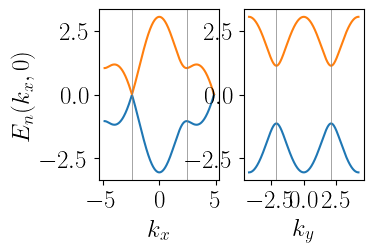

In [5]:
deltam = -0.001

t2 = 0.1 #0.1
phi = pi/2
m = 3sqrt(3) * t2 + deltam

μ = 1.0

nplot = 400

BZedgex = 4pi / 3
BZedgey = 8pi / (3sqrt(3))
kxplot = range(-BZedgex, BZedgex; length=nplot)
kyplot = range(-BZedgey, BZedgey; length=nplot)

bands = [eigvals(haldane([kx, ky], t2, phi, m)) for kx in kxplot, ky in kyplot]

fig, axs = subplots(ncols=2, figsize=(246/72, 160/72))
axs[1].plot(kyplot, bands[div(nplot, 2), :]);
axs[2].plot(kxplot, bands[:, div(nplot, 2)]);

axs[1].axvline(-4pi/(3sqrt(3)), color="gray", linewidth=0.5)
axs[1].axvline(4pi/(3sqrt(3)), color="gray", linewidth=0.5)

axs[2].axvline(-2pi / 3, color="gray", linewidth=0.5)
axs[2].axvline(2pi / 3, color="gray", linewidth=0.5)

axs[1].set_xlabel(L"$k_x$")
axs[2].set_xlabel(L"$k_y$")
axs[1].set_ylabel(L"$E_n(k_x, 0)$")

gap = minimum(b[2] for b in bands) - maximum(b[1] for b in bands)
println("Gap ≈ $gap")

In [6]:
function tobins(i, nbit)
    @assert 1 ≤ i ≤ 2^nbit
    mask = 1 << (nbit-1)
    bin = ones(Int, nbit)
    for n in 1:nbit
        bin[n] = (mask & (i-1)) >> (nbit-n) + 1
        mask = mask >> 1
    end
    return bin
end

function frombins(bin)
    @assert all(1 .≤ bin .≤ 2)
    nbit = length(bin)
    i = 1
    tmp = 2^(nbit-1)
    for n in eachindex(bin)
        i += tmp * (bin[n] -1)
        tmp = tmp >> 1
    end
    return i
end

@assert frombins(tobins(4, 10)) == 4

In [7]:
function genfunc(t2, ϕ, m, β, μ)
    BZedgex = 4pi / 3
    BZedgey = 8pi / (3sqrt(3))
    function gkb(b)
        nbit = length(b) ÷ 2
        N = 2^nbit
        dkx = 2*BZedgex/N
        dky = 2*BZedgey/N
        ikx = frombins(b[1:2:end])
        iky = frombins(b[2:2:end])
        k = [dkx * (ikx-1) - BZedgex, dky * (iky-1) - BZedgey]
        return ghaldane(k, t2, ϕ, m, β, μ)
    end
end

function gengkdata(gkb, nbit)
    N = 2^nbit
    gkdata = zeros(ComplexF64, N, N)
    for ikx in 1:N, iky in 1:N
        bx = tobins(ikx, nbit)
        by = tobins(iky, nbit)
        b = collect(Iterators.flatten(zip(bx, by)))
        gkdata[ikx, iky] = gkb(b)
    end
    return gkdata
end
#gkdata = gengkdata(genfunc(t2, phi, m, β, μ), 10)
#pcolormesh(abs.(gkdata))

gengkdata (generic function with 1 method)

In [8]:
#betas = [1.0, 4.0, 16.0, 64.0]
#tols = [1e-3, 1e-4, 1e-5]
#cutoffs_mps = [1e-6, 1e-8, 1e-10, 1e-12, 1e-14]
beta = 512.0
nbits = [10, 12, 14, 20, 30]
Dmax = 100

100

In [9]:
sites_nbit = Dict()
for nbit in nbits
    sitesx =  [Index(2, "Qubit,kx=$k") for k in 1:nbit]
    sitesy =  [Index(2, "Qubit,ky=$k") for k in 1:nbit]
    sites = collect(Iterators.flatten(zip(sitesx, sitesy)))
    sites_nbit[nbit] = sites
end

# TCI

In [10]:
func = genfunc(t2, phi, m, beta, μ)
timings_tci = Dict{Int,Float64}()

for _ in 1:2
for nbit in nbits
    @show nbit
    firstpivot = TCI.optfirstpivot(func, fill(2, 2*nbit))
    t1 = time_ns()
    @time qtt, ranks, errors = TCI.crossinterpolate(
        ComplexF64, func, fill(2, 2*nbit),
        firstpivot, tolerance=1e-20, maxiter=Dmax, verbosity=1
    )
    t2 = time_ns()
    #@show maximum(TCI.linkdims(qtt))
    @show TCI.linkdims(qtt)
    timings_tci[nbit] = 1e-9 * (t2 - t1)
end
end

nbit = 10
rank= 10 , error= 9.48904805625233
rank= 20 , error= 7.737883875395114
rank= 30 , error= 7.77466337999386
rank= 40 , error= 7.226441616777893
rank= 50 , error= 5.635359711372855
rank= 60 , error= 1.0695098819109445
rank= 70 , error= 0.23732621995080266
rank= 80 , error= 0.008370320868769071
rank= 90 , error= 0.0009445348938690905
rank= 100 , error= 0.00011700495779041957
  9.174473 seconds (40.25 M allocations: 3.967 GiB, 7.75% gc time, 67.29% compilation time)
TCI.linkdims(qtt) = [1, 2, 4, 8, 14, 19, 37, 69, 100, 100, 100, 100, 100, 64, 32, 16, 8, 4, 2]
nbit = 12
rank= 10 , error= 11.103403488305618
rank= 20 , error= 11.634175916954588
rank= 30 , error= 7.502548949454509
rank= 40 , error= 7.1748986359263265
rank= 50 , error= 5.783872569476444
rank= 60 , error= 3.8126747138935935
rank= 70 , error= 2.668403545539852
rank= 80 , error= 1.5151474122816797
rank= 90 , error= 1.0995556666359414
rank= 100 , error= 0.6560328869916676
  5.284022 seconds (37.02 M allocations: 5.317 GiB,

In [11]:
timings_tci

Dict{Int64, Float64} with 5 entries:
  20 => 14.5872
  10 => 2.70926
  12 => 4.86822
  30 => 30.025
  14 => 7.0488

# SVD

In [12]:
timings_svd = Dict{Int,Float64}()

for _ in 1:2
for nbit in [8, 10, 12]
    sitesx =  [Index(2, "Qubit,kx=$k") for k in 1:nbit]
    sitesy =  [Index(2, "Qubit,ky=$k") for k in 1:nbit]
    sites = collect(Iterators.flatten(zip(sitesx, sitesy)))
    t1 = time_ns()
    let
        data_ref = gengkdata(genfunc(t2, phi, m, beta, μ), nbit)
        tensor = ITensor(data_ref, vcat(reverse(sitesx), reverse(sitesy)))
        M = MPS(tensor, sites; maxdim=Dmax)
    end
    t2 = time_ns()
    timings_svd[nbit] = (t2 - t1) * 1e-9
end
end

In [13]:
timings_svd

Dict{Int64, Float64} with 3 entries:
  10 => 9.92696
  12 => 170.091
  8  => 0.587281

In [1]:
fig = figure(figsize=(6.4, 2.8))
annotate("(c)", xycoords="axes fraction", xy=(-0.2,0.90), fontsize=21)

annotate(L"\beta=%$(Int(beta)), D_\mathrm{max}=%$(Dmax)", xycoords="axes fraction", xy=(0.02,0.86), fontsize=18)
#annotate(L"D_\mathrm{max}=%$(Dmax)", xycoords="axes fraction", xy=(0.02,0.72), fontsize=18)

pcolors = ["r", "b", "g", "k"]
markers = ["o", "x", "v", "+"]
ls = ["-", "-.", "--", ":"]

x = sort(collect(keys(timings_tci)))
semilogy(x, [timings_tci[k] for k in x], marker=markers[1], ls=ls[1], color=pcolors[1], label="TCI")

x = sort(collect(keys(timings_svd)))
semilogy(x, [timings_svd[k] for k in x], marker=markers[2], ls=ls[2], color=pcolors[2], label="SVD")

annotate(L"\propto N", xycoords="axes fraction", xy=(0.5, 0.65), fontsize=18)

x = Float64[8, 30]

semilogy(x, 2*x, label="", ls="--", color="k", lw=1.0)
#loglog(x, x .^ 4, label="", ls="-.", color="k", lw=1.0)

#xlabel(L"D_\mathrm{max}")
xlabel(L"N")
ylabel("Timings [s]")
ylim([0.2,2000])
legend(frameon=false, loc="lower right", fontsize=16)

tight_layout()
savefig("dyson-c.pdf", bbox_inches="tight", transparent=true, rasterized=true)

display(gcf())
close(gcf())

LoadError: UndefVarError: figure not defined

In [15]:
@show collect(keys(timings_svd))
@show collect(values(timings_svd))

collect(keys(timings_svd)) = [10, 12, 8]
collect(values(timings_svd)) = [9.926963504000001, 170.09076205800002, 0.5872807160000001]


3-element Vector{Float64}:
   9.926963504000001
 170.09076205800002
   0.5872807160000001